# MNIST Simple Pointer Network

In this notebook we will learn how to create a simple [Pointer Network](https://arxiv.org/abs/1506.03134) (Vinyals et al. 2015) for solving a dummy task on the MNIST dataset.

A Pointer Network uses the **attention mechanism’s** output to model the conditional probability of each element on its input. This can be extremely useful in tasks that require selecting one (or more) elements of the input sequence/set to be solved.

In this notebook we will play with a simple Pointer net to solve the following task: Given an MNIST image with a (query) digit we want our model to find the image that contains the consecutive digit to the query image among a set of input images. For example, imagine we use an image with the digit "5" as query and let the input of the model be a set of 10 images with different digits, the output of our model must be a probability distribution over those 10 images indicating the presence or not of the digit "6" in each of them.

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch Version:  1.11.0+cu113
Using device: cuda:0


### Create the dataset

Let's start creating a Dataset class to understand better the task we want to solve. Each sample in out dataset will be formed by:

* a query image
* a set of 10 images, 9 of them selected randomly (distractors) and one selected as the consecutive digit of the digit in the query image.
* the ground truth: a 10-D one hot vector indicating the position of the image we want our model to select ("point to").

In [ ]:
class MNISTAttentionDataset(Dataset):
    """MNIST attention toy dataset."""

    def __init__(self, num_inputs, train=True):
        """
        Args:
            num_inputs (int) - The number of images in the input of our model.
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
        """
        
        self.num_inputs = num_inputs
        self.mnist = datasets.MNIST('../data', train=train, download=True)
        
        # dict with samples for each class label
        self.data = {}
        for label in range(10):
            self.data[label] = self.mnist.data[self.mnist.targets == label] / 255.

        

    def __len__(self):
        return self.mnist.data.shape[0]

    def __getitem__(self, idx):

        c = np.random.randint(0,10)
        idx = np.random.randint(0, self.data[c].shape[0])
        query = self.data[c][idx,:].flatten()

        correct_pos = np.random.randint(0,self.num_inputs)
        
        inputs = np.zeros((self.num_inputs, 784))
        for j in range(self.num_inputs):
          if j == correct_pos:
            idx = np.random.randint(0,self.data[(c+1)%10].shape[0])
            inputs[j,:] = self.data[(c+1)%10][idx,:].flatten()
          else:
            c_distractor = np.random.choice([n for n in [0,1,2,3,4,5,6,7,8,9] if n!=(c+1)%10])
            idx = np.random.randint(0,self.data[c_distractor].shape[0])
            inputs[j,:] = self.data[c_distractor][idx,:].flatten()
            
        sample = {'x': inputs, 'query': query, 'y': correct_pos}

        return sample



In [ ]:
num_inputs = 10

train_dataset = MNISTAttentionDataset(num_inputs, train=True)
test_dataset = MNISTAttentionDataset(num_inputs, train=False)

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

cuda_kwargs = {'num_workers': 0,
               'pin_memory': True,
               'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(train_dataset, **train_kwargs)
test_loader  = DataLoader(test_dataset, **test_kwargs)

### Visualize one training sample

(10, 784) torch.Size([784])


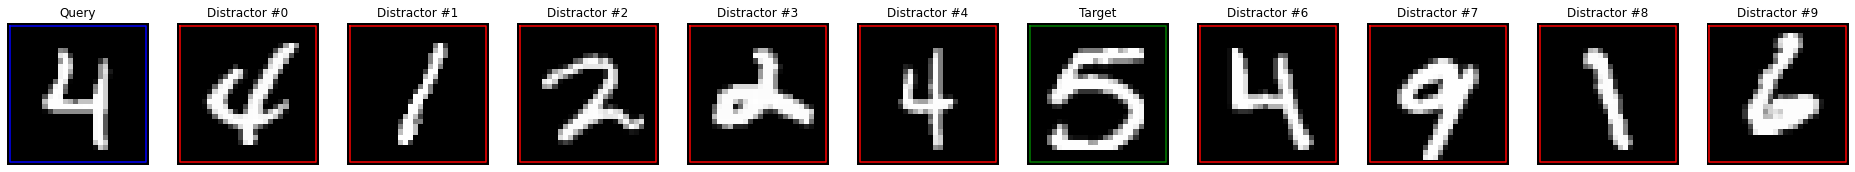

In [ ]:
sample = train_dataset[0]

print(sample['x'].shape, sample['query'].shape)

fig = plt.figure(figsize=(33, 3))
plt.tight_layout()

ax = plt.subplot(1, num_inputs + 1, 1)
image = sample['query'].reshape(28,28)
plt.imshow(image, cmap='gray')
plt.plot([0,27,27,0,0], [0,0,27,27,0], c='b')
ax.set_title('Query')
ax.axis('off')

for i in range(num_inputs):
    ax = plt.subplot(1, num_inputs + 1, i+2)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    image = sample['x'][i].reshape(28,28)
    plt.imshow(image, cmap='gray')
    if i == sample['y']:
      plt.plot([0,27,27,0,0], [0,0,27,27,0], c='g')
      ax.set_title('Target')
    else:
      plt.plot([0,27,27,0,0], [0,0,27,27,0], c='r')
      ax.set_title('Distractor #{}'.format(i))
    ax.axis('off')
  


ax.axis('off')

plt.show()

### Create the model

In [ ]:
class AttentionModel(nn.Module):
    def __init__(self, input_dim, num_inputs, hidden_dim):
        super(AttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_inputs = num_inputs
        self.input_dim  = input_dim

        # Weights (Fully Connected layers) 
        self.fc_q = nn.Linear(input_dim, hidden_dim) # Query FC
        self.fc_k = nn.Linear(input_dim, hidden_dim) # Keys FC. Here the input acts as the keys, and there is no value
        self.fc_v = nn.Linear(hidden_dim, 1) # Values FC

    def scoringAdditive(self, query, keys):
        #Query is                                               (B X 1 X input_dim)
        # Repeat (tile) the query so that it has the same size as the keys (input)
        query = query.repeat(1, self.num_inputs, 1)           # (B X num_inputs X input_dim)
        query = torch.tanh(self.fc_q(query))                  # (B X num_inputs X hidden_dim)

        #Keys is                                                (B X num_inputs X input_dim)
        keys = torch.tanh(self.fc_k(keys))                    # (B X num_inputs X hidden_dim)
        score = torch.tanh(query + keys )                     # (B X num_inputs X hidden_dim)
        score = self.fc_v(score)                              # (B X num_inputs X 1)        
        return score

    def forward(self, x, query):
        query = query.unsqueeze(1) # (B x input_dim) -> (B x 1 x input_dim)
        
        # Calculate attention scores
        output = self.scoringAdditive(query, x)
        output = output.squeeze()       # (B x 1 x num_inputs) -> (B x num_inputs)
        return output

<font color="blue">

**QUESTION**: The Additive score gives logits that we should pass through a softmax to get the final attention weights. Why is there no softmax in the model above?</font>

<font color="green">
    
**ANSWER**: The loss function we use to train this, although is the `nn.CrossEntropyLoss()`. Although it is called "CrossEntropy" in reality it expects logits, and does the softmax and the cross entropy jointly. This is why we do not do softmax explicitly before.</font>

In [ ]:
input_dim, num_inputs, hidden_dim = (784, 10, 256)

model = AttentionModel(input_dim, num_inputs, hidden_dim)
print(model)

AttentionModel(
  (fc_q): Linear(in_features=784, out_features=256, bias=True)
  (fc_k): Linear(in_features=784, out_features=256, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
)


### Define the training method and train

In [ ]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    # Method to perform one epoch of training
    model.train()
    loss_values = []
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['x'].float()
        query = sample_batched['query'].float()
        target = sample_batched['y']
        #print(data.shape, query.shape)
        data, query, target = data.to(device), query.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data, query)
        loss = criterion(output, target)
        loss_values.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
    return loss_values

In [ ]:
model = model.to(device)

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

epochs = 10

log_interval = 100 # how many batches to wait before logging training status

loss_history = []
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, criterion, optimizer, epoch)
    loss_history += loss_values

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305063
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.698086
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.172141
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.840435
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.745771
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.616521
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.483020
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.557374
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.547336
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.532275
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.510775
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.550929
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.437685
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.429042
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.379633
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.488067
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.549283
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.283117
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.341035
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.360656
Train Epoch:

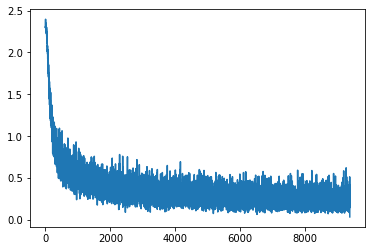

In [ ]:
plt.plot(loss_history)

### Evaluate the trained model

In [ ]:
def evaluate(model, device, test_loader):
    model.eval()
    total = 0.
    ok = 0.
    for batch_idx, sample_batched in enumerate(test_loader):
        data = sample_batched['x'].float()
        query = sample_batched['query'].float()
        target = sample_batched['y'].numpy()
        data, query = data.to(device), query.to(device)
        
        output = model(data, query)
        pred = np.argmax(output.detach().cpu().numpy(), axis=1)
       
        ok += np.sum(pred == target)
        total += len(test_loader)
                
    print('Accuracy = ', ok/total)

In [ ]:
evaluate(model, device, test_loader)

Accuracy =  91.9


<font color="blue">

**EXERCISE 1**: Starting from the previous model as a template, implement the Dot-product Attention scoring function and substitute the additive one we were using before. Retrain and evalute the model.</font>

<font color="blue">

> Hint: To transpose a tensor along specific dimensions you can use `torch.permute()`
</font>


<font color="blue">

> Hint: To perform a batch matrix-matrix product, use the function `torch.bmm()` https://pytorch.org/docs/stable/generated/torch.bmm.html 
</font>

In [ ]:
# YOUR CODE HERE


In [ ]:
# SOLUTION

class AttentionModel_Dot(nn.Module):
    def __init__(self, input_dim, num_inputs, hidden_dim):
        super(AttentionModel_Dot, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_inputs = num_inputs
        self.input_dim  = input_dim

        # Weights (Fully Connected layers) 
        self.fc_q = nn.Linear(input_dim, hidden_dim) # Query FC
        self.fc_k = nn.Linear(input_dim, hidden_dim) # Keys FC. Here the input acts as the keys, and there is no value
        self.fc_v = nn.Linear(hidden_dim, 1) # Values FC

    def scoringAdditive(self, query, keys):
        #Query is                                               (B X 1 X input_dim)
        # Repeat (tile) the query so that it has the same size as the keys (input)
        query = query.repeat(1, self.num_inputs, 1)           # (B X num_inputs X input_dim)
        query = torch.tanh(self.fc_q(query))                  # (B X num_inputs X hidden_dim)

        #Keys is                                                (B X num_inputs X input_dim)
        keys = torch.tanh(self.fc_k(keys))                    # (B X num_inputs X hidden_dim)
        score = torch.tanh(query + keys )                     # (B X num_inputs X hidden_dim)
        score = self.fc_v(score)                              # (B X num_inputs X 1)        
        return score

    def scoringDot(self, query, keys):        
        #Query is                                               (B X 1 X input_dim)
        query = torch.tanh(self.fc_q(query))                  # (B X 1 X hidden_dim)
        #Keys is                                                (B X num_inputs X input_dim)
        keys = torch.tanh(self.fc_k(keys))                    # (B X num_inputs X hidden_dim)

        keys = keys.permute(0,2,1)                            # (B X hidden_dim X num_inputs)
        score = torch.bmm(query, keys)                        # (B X 1 X num_inputs)
        score /= np.sqrt(num_inputs)
        score = score.permute(0,2,1)                          # (B X num_inputs x 1)
        return score

    def forward(self, x, query):
        query = query.unsqueeze(1) # (B x input_dim) -> (B x 1 x input_dim)
        
        # Calculate attention scores
        output = self.scoringDot(query, x)
        output = output.squeeze()       # (B x 1 x num_inputs) -> (B x num_inputs)
        return output

In [ ]:
# SOLUTION (cont)

input_dim, num_inputs, hidden_dim = (784, 10, 256)

modelDot = AttentionModel_Dot(input_dim, num_inputs, hidden_dim)
print(modelDot)

AttentionModel_Dot(
  (fc_q): Linear(in_features=784, out_features=256, bias=True)
  (fc_k): Linear(in_features=784, out_features=256, bias=True)
  (fc_v): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
# SOLUTION (cont)

modelDot = modelDot.to(device)

optimizer = optim.Adam(modelDot.parameters())

criterion = nn.CrossEntropyLoss()

epochs = 10

log_interval = 100 # how many batches to wait before logging training status

loss_history = []
for epoch in range(1, epochs + 1):
    loss_values = train(modelDot, device, train_loader, criterion, optimizer, epoch)
    loss_history += loss_values

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.288806
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.179607
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.745618
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.775333
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.017786
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.815794
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.483762
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.413168
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.377601
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.323278
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.444749
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.388522
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.474860
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.408333
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.129659
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.339016
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.290997
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.315909
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.252778
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.377045
Train Epoch:

In [ ]:
# SOLUTION (cont)

evaluate(modelDot, device, test_loader)

Accuracy =  94.73


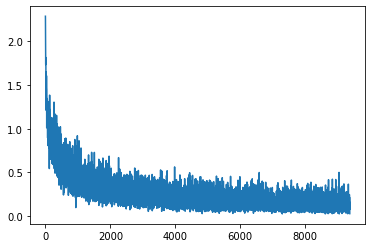

In [ ]:
# SOLUTION (cont)

plt.plot(loss_history)